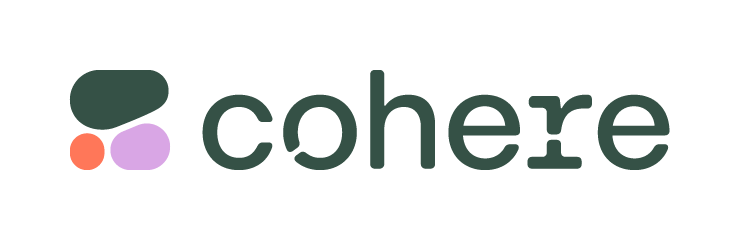

Large Language Models (LLMs) are becoming increasingly capable of comprehending text, among others excelling in document analysis. The new Cohere model, [Command-R](https://huggingface.co/CohereForAI/c4ai-command-r-v01), boasts a context length of 128k, which makes it particularly effective for such tasks. Nevertheless, even with the extended context window, some documents might be too lengthy to accommodate in full.

In this cookbook, we'll explore techniques to address cases when relevant information doesn't fit in the model context window.

We'll show you three potential mitigation strategies: truncating the document, query-based retrieval, and a "text rank" approach we use internally at Cohere.

### Table of content:
1. [Getting started](#getting-started)
2. [Approach 1: Truncate](#truncate)
3. [Approach 2: Query Based Retrieval](#query-based-retrieval)
4. [Approach 3: Text Rank](#text-rank)

### Summary

| Approach     | Description               | Pros                                      | Cons                       | When to use?                       |
|-----------------------|-------------------------------------------|-------------------------------------------|-------------------------------------------|-------------------------------------------|
| Truncation            | Truncate the document to fit the context window.                    | - Simplicity of implementation<br>(does not rely on extrenal infrastructure)| - Loses information at the end of the document | Utilize when all relevant information is contained<br> at the beginning of the document. |
| Query Based Retrieval| Utilize semantic similarity to retrieve text chunks<br> that are most relevant to the query. | - Focuses on sections directly relevant to<br> the query | - Relies on a semantic similarity algorithm.<br>- Might lose broader context | Employ when seeking specific<br> information within the text. |
| Text Rank             | Apply graph theory to generate a cohesive set<br> of chunks that effectively represent the document. | - Preserves the broader picture.          | - Might lose detailed information. | Utilize in summaries and when the question<br> requires broader context. |







<a id="getting-started"></a>
<a name="getting-started"></a>
# Getting Started

In [ ]:
####################################################################################################
#
# Uncomment if you need to install the following packages
#
####################################################################################################
# %%capture
# !pip install cohere
# !pip install python-dotenv
# !pip install tokenizers
# !pip install langchain
# !pip install nltk
# !pip install networkx
# !pip install pypdf2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.1 MB/s eta 0:00:00
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 324, in run
    session = self.get_default_session(options)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 98, in get_default_session
    self._session = self.enter_context(self._build_session(options))
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 125, in _build_session
    session = PipSession(
  File "/usr/l

In [ ]:
import os
import requests
from collections import deque
from typing import List, Tuple

import cohere

import numpy as np

import PyPDF2
from dotenv import load_dotenv

from tokenizers import Tokenizer

import nltk
nltk.download('punkt')  # Download the necessary data for sentence tokenization
from nltk.tokenize import sent_tokenize

import networkx as nx
from getpass import getpass
from IPython.display import HTML, display

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


False

In [ ]:
def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

set_css()

In [ ]:
# Set up Cohere client
co_model = 'command-r'
co_api_key = getpass("Enter your Cohere API key: ")
co = cohere.Client(api_key=co_api_key)

Enter your Cohere API key: ··········


In [ ]:
def load_long_pdf(file_path):
    """
    Load a long PDF file and extract its text content.

    Args:
        file_path (str): The path to the PDF file.

    Returns:
        str: The extracted text content of the PDF file.
    """
    with open(file_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        num_pages = len(pdf_reader.pages)
        full_text = ''
        for page_num in range(num_pages):
            page = pdf_reader.pages[page_num]
            full_text += page.extract_text()
    return full_text

def save_pdf_from_url(pdf_url, save_path):
    try:
        # Send a GET request to the PDF URL
        response = requests.get(pdf_url, stream=True)
        response.raise_for_status()  # Raise an exception for HTTP errors

        # Open the local file for writing in binary mode
        with open(save_path, 'wb') as file:
            # Write the content of the response to the local file
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)

        print(f"PDF saved successfully to '{save_path}'")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading PDF: {e}")

In this example we use the Proposal for a Regulation of the European Parliament and of the Council defining rules on Artificial Intelligence from 26 January 2024, [link](https://data.consilium.europa.eu/doc/document/ST-5662-2024-INIT/en/pdf).

In [ ]:
# Download the PDF file from the URL
pdf_url = 'https://data.consilium.europa.eu/doc/document/ST-5662-2024-INIT/en/pdf'
save_path = 'example.pdf'
save_pdf_from_url(pdf_url, save_path)

# Load the PDF file and extract its text content
long_text = load_long_pdf(save_path)
long_text = long_text.replace('\n', ' ')

# Print the length of the document
print("Document length - #tokens:", len(co.tokenize(long_text)))

PDF saved successfully to 'example.pdf'
Document length - #tokens: 128618


## Summarizing the text

In [ ]:
def generate_response(message, max_tokens=300, temperature=0.2, k=0):
  """
  A wrapper around the Cohere API to generate a response based on a given prompt.

  Args:
    messsage (str): The input message for generating the response.
    max_tokens (int, optional): The maximum number of tokens in the generated response. Defaults to 300.
    temperature (float, optional): Controls the randomness of the generated response. Higher values (e.g., 1.0) make the output more random, while lower values (e.g., 0.2) make it more deterministic. Defaults to 0.2.
    k (int, optional): Controls the diversity of the generated response. Higher values (e.g., 5) make the output more diverse, while lower values (e.g., 0) make it more focused. Defaults to 0.

  Returns:
    str: The generated response.

  """
  response = co.chat(
    model = co_model,
    message=message,
    max_tokens=max_tokens,
    temperature=temperature,
    return_prompt=True
    )
  return response.text

In [ ]:
# Example summary prompt.
prompt_template = """
## Instruction
Summarize the following Document in 3-5 sentences. Only answer based on the information provided in the document.

## Document
{document}

## Summary
""".strip()

If you run the cell below, an error will occur. Therefore, in the following sections, we will explore some techniques to address this limitation.

Error: :`CohereAPIError: too many tokens:`



In [ ]:
prompt = prompt_template.format(document=long_text)
# print(generate_response(message=prompt))

Therefore, in the following sections, we will explore some techniques to address this limitation.

<a name="truncate"></a>
# Approach 1 - Truncate

First we try to truncate the document so that it meets the length constraints. This approach is simple to implement and understand. However, it drops potentially important information contained towards the end of the document.

In [ ]:
# The new Cohere model has a context limit of 128k tokens. However, for the purpose of this exercise, we will assume a smaller context window.
# Employing a smaller context window also has the additional benefit of reducing the cost per request, especially if billed by the number of tokens.

MAX_TOKENS = 40000

def truncate(long: str, max_tokens: int) -> str:
    """
    Shortens `long` by brutally truncating it to the first `max_tokens` tokens.
    This can break up sentences, passages, etc.
    """

    tokenized = co.tokenize(long).token_strings
    truncated = tokenized[:max_tokens]
    short = "".join(truncated)
    return short

In [ ]:
short_text = truncate(long_text, MAX_TOKENS)

prompt = prompt_template.format(document=short_text)
print(generate_response(message=prompt))

The document outlines the European Union's proposed Regulation on Artificial Intelligence, aiming to establish harmonised rules for AI development and use while ensuring fundamental rights protection. It defines the scope, purposes, and risks addressed, excluding national security and military purposes. Prohibited AI practices, such as real-time biometric identification in public spaces, are detailed. The regulation proposes a risk-based approach, classifying high-risk AI systems and setting requirements for providers and deployers. It establishes governance structures and obligations for general-purpose AI models, including transparency and copyright compliance. The document also covers issues like conformity assessment, responsibilities along the AI value chain, and standardisation. The regulation aims to foster trustworthy AI while protecting public interests and fundamental rights.


<a name="query-based-retrieval"></a>
# Approach 2: Query Based Retrieval

In this section we present how we can leverage a query retriereval based approach to generate an answer to the following question: `Based on the document, are there any risks related to Elon Musk?`.

The solution is outlined below and can be broken down into four functional steps.

1. Chunk the text into units
    - Here we employ a simple chunking algorithm. More information about different chunking strategies can be found [here](TODO: link to chunking post).

2. Use a ranking algorithm to rank chunks against the query
    - We leverage another Cohere endpoint, `co.rerank` ([docs link](https://docs.cohere.com/reference/rerank-1)), to rank each chunk against the query.

3. Keep the most-relevant chunks until context limit is reached
    - `co.rerank` returns a relevance score, facilitating the selection of the most pertinent chunks. We can choose the most relevant chunks based on this score.

4. Put condensed text back in original order
    - Finally, we arrange the chosen chunks in their original sequence as they appear in the document.

See `query_based_retrieval` function for the starting point.


### Query based retrieval implementation

In [ ]:
############################################################
#
# Utility functions for chunking
#
############################################################
def split_text_into_sentences(text) -> List[str]:
    """
    Split the input text into a list of sentences.
    """
    sentences = sent_tokenize(text)

    return sentences

def group_sentences_into_passages(sentence_list, n_sentences_per_passage=5):
    """
    Group sentences into passages of n_sentences sentences.
    """
    passages = []
    passage = ""
    for i, sentence in enumerate(sentence_list):
        passage += sentence + " "
        if (i + 1) % n_sentences_per_passage == 0:
            passages.append(passage)
            passage = ""
    return passages

def build_simple_chunks(text, n_sentences=5):
    """
    Build chunks of text from the input text.
    """
    sentences = split_text_into_sentences(text)
    chunks = group_sentences_into_passages(sentences, n_sentences_per_passage=n_sentences)
    return chunks

In [ ]:
sentences = split_text_into_sentences(long_text)
passages = group_sentences_into_passages(sentences, n_sentences_per_passage=5)
print('Example sentence:', np.random.choice(np.asarray(sentences), size=1, replace=False))
print()
print('Example passage:', np.random.choice(np.asarray(passages), size=1, replace=False))

Example sentence: ['This is to ensure that the deployer is aware and takes them into acc ount when using the  high - risk AI system.']

Example passage: ['Notified bodies shall have procedures for the performance of activities which take due  account of the size of an undertaking, th e sector in which it operates, its structure, the  degree of complexity of the AI system in question. 8. Notified bodies shall take out appropriate liability insurance for their conformity  assessment activities, unless liability is assumed by the Member Sta te in which they are  established in accordance with national law or that Member State is itself directly  responsible for the conformity assessment. 9. Notified bodies shall be capable of carrying out all the tasks falling to them under this  Regulation with   the highest degree of professional integrity and the requisite competence  in the specific field, whether those tasks are carried out by notified bodies themselves or on  their behalf and under 

In [ ]:
def _add_chunks_by_priority(
    chunks: List[str],
    idcs_sorted_by_priority: List[int],
    max_tokens: int,
) -> List[Tuple[int, str]]:
    """
    Given chunks of text and their indices sorted by priority (highest priority first), this function
    fills the model context window with as many highest-priority chunks as possible.

    The output is a list of (index, chunk) pairs, ordered by priority. To stitch back the chunks into
    a cohesive text that preserves chronological order, sort the output on its index.
    """

    selected = []
    num_tokens = 0
    idcs_queue = deque(idcs_sorted_by_priority)

    while num_tokens < max_tokens and len(idcs_queue) > 0:
        next_idx = idcs_queue.popleft()
        num_tokens += co.tokenize(chunks[next_idx]).length
        # keep index and chunk, to reorder chronologically
        selected.append((next_idx, chunks[next_idx]))
    if num_tokens > max_tokens:
        selected.pop()

    return selected

def query_based_retrieval(
    long: str,
    max_tokens: int,
    query: str,
    n_setences_per_passage: int = 5,
) -> str:
    """
    Performs query-based retrieval on a long text document.
    """
    # 1. Chunk text into units
    chunks = build_simple_chunks(long, n_setences_per_passage)

    # 2. Use co.rerank to rank chunks vs. query
    chunks_reranked = co.rerank(query=query, documents=chunks, model="rerank-english-v3.0")
    idcs_sorted_by_relevance = [
        chunk.index for chunk in sorted(chunks_reranked, key=lambda c: c.relevance_score, reverse=True)
    ]

    # 3. Add chunks back in order of relevance
    selected = _add_chunks_by_priority(chunks, idcs_sorted_by_relevance, max_tokens)

    # 4. Put condensed text back in original order
    separator = " "
    short = separator.join([chunk for index, chunk in sorted(selected, key=lambda item: item[0], reverse=False)])
    return short

In [ ]:
# Example prompt
prompt_template = """
## Instruction
{query}

## Document
{document}

## Answer
""".strip()

In [ ]:
query = "What does the report say about biometric identification? Answer only based on the document."
short_text = query_based_retrieval(long_text, MAX_TOKENS, query)
prompt = prompt_template.format(query=query, document=short_text)
print(generate_response(message=prompt, max_tokens=300))

The report discusses the regulation of biometric identification, specifically the use of real-time systems in publicly accessible spaces for law enforcement purposes. The use of these systems is generally prohibited except in certain circumstances, such as searching for missing people or identifying perpetrators of serious criminal offences.

The report outlines a number of exceptions and additional prohibitions related to biometric identification. For instance, biometric categorisation based on specific beliefs or characteristics is generally prohibited, along with untargeted scraping of facial images for creating facial recognition databases.

Additionally, the document mentions post-remote biometric identification, which is subject to additional safeguards. These include authorisation requirements and restrictions on their use for law enforcement purposes.

The regulation also addresses the accuracy, robustness and cybersecurity of AI systems, including high-risk systems that involv

<a name="text-rank"></a>
# Approach 3: Text rank

In the final section we will show how we leverage graph theory to select chunks based on their centrality. Centrality is a graph-theoretic measure of how connected a node is; the higher the centrality, the more connected the node is to surrounding nodes (with fewer connections among those neighbors).

The solution presented in this document can be broken down into five functional steps:

1. Break the document into chunks.
    - This mirrors the first step in [Approach 2](#query-based-retrieval).

2. Embed each chunk using an embedding model and construct a similarity matrix.
    - We utilize `co.embed` [documentation link](https://docs.cohere.com/reference/embed).

3. Compute the centrality of each chunk.
    - We employ a package called [`NetworkX`](https://networkx.org/documentation/networkx-1.10/overview.html). It constructs a graph where the chunks are nodes, and the similarity score between them serves as the weight of the edges. Then, we calculate the centrality of each chunk as the sum of the edge weights adjacent to the node representing that chunk.

4. Retain the highest-centrality chunks until the context limit is reached.
    - This step follows a similar approach to [Approach 2](#query-based-retrieval).

5. Reassemble the shortened text by reordering chunks in their original order.
    - This step mirrors the last step in [Approach 2](#query-based-retrieval).

See `text_rank` as the starting point.


### Text rank implementation

In [ ]:
def text_rank(text: str, max_tokens: int, n_setences_per_passage: int) -> str:
    """
    Shortens text by extracting key units of text from it based on their centrality.
    The output is the concatenation of those key units, in their original order.
    """

    # 1. Chunk text into units
    chunks = build_simple_chunks(text, n_setences_per_passage)

    # 2. Embed and construct similarity matrix
    embeddings = np.array(
        co.embed(
            texts=chunks,
            model="embed-english-v3.0",
            input_type="clustering",
        ).embeddings
    )
    similarities = np.dot(embeddings, embeddings.T)

    # 3. Compute centrality and sort sentences by centrality
    # Easiest to use networkx's `degree` function with similarity as weight
    g = nx.from_numpy_array(similarities, edge_attr="weight")
    centralities = g.degree(weight="weight")
    idcs_sorted_by_centrality = [node for node, degree in sorted(centralities, key=lambda item: item[1], reverse=True)]

    # 4. Add chunks back in order of centrality
    selected = _add_chunks_by_priority(chunks, idcs_sorted_by_centrality, max_tokens)

    # 5. Put condensed text back in original order
    short = " ".join([chunk for index, chunk in sorted(selected, key=lambda item: item[0], reverse=False)])

    return short

In [ ]:
# Example summary prompt.
prompt_template = """
## Instruction
Summarize the following Document in 3-5 sentences. Only answer based on the information provided in the document.

## Document
{document}

## Summary
""".strip()

In [ ]:
short_text = text_rank(long_text, MAX_TOKENS, 5)
prompt = prompt_template.format(document=short_text)
print(generate_response(message=prompt, max_tokens=600))

The document outlines the European Union's Artificial Intelligence Act, which aims to regulate AI systems and models while promoting innovation. It establishes rules for developing, using, and monitoring AI, especially high-risk systems, to protect public interests and fundamental rights. The Act mandates risk management systems, data governance requirements, and transparency measures for high-risk AI. It also sets obligations for providers and deployers, including registration, and empowers competent authorities to enforce compliance. Additionally, it encourages codes of conduct and provides for AI regulatory sandboxes to support innovation. The EU will establish a database for high-risk AI systems, and the Commission will coordinate enforcement and promote best practices. Fines and penalties are proposed for non-compliance. The Act seeks to balance AI development and oversight, ensuring trustworthy and responsible use while fostering the EU's AI ecosystem.


## Summary

In this notebook we present three useful methods to over come the limitations of context window size. In the following [blog post](TODO:add link), we talk more about how these methods can be evaluated.